## 문제 정의
- 클래스 변수가 하나의 값에 치우친 데이터로 학습한 분류 모델이 치우친 클래스에 대해 편향되는 문제로, 이러한 모델은 대부분 샘플을 치우친 클래스 값으로만 분류하게 됨(예시: 암환자 판별 문제)
- 클래스 불균형 문제가 있는 모델은 정확도가 높고, 재현율이 매우 낮은 경향이 있음
- 원본 데이터가 작을 때 오버샘플링이 유용하고, 많을 때는 언더 샘플링이 유용하다.

## 어디에 만들고 어느 것을 지울까?
- 결정 경계에 가까운 다수 클래스 샘플을 제거하고, 결정 경계에 가까운 소수 클래스 샘플을 생성해야한다.

### 대표적인 오버샘플링 알고리즘: SMOTE
- 소수 클래스 샘플을 임의로 선택하고, 선택된 샘플의 이웃 가운데 하나의 샘플을 또 임의로 선택하여 그 중간에 샘플을 생성하는 과적을 반복하는 방법
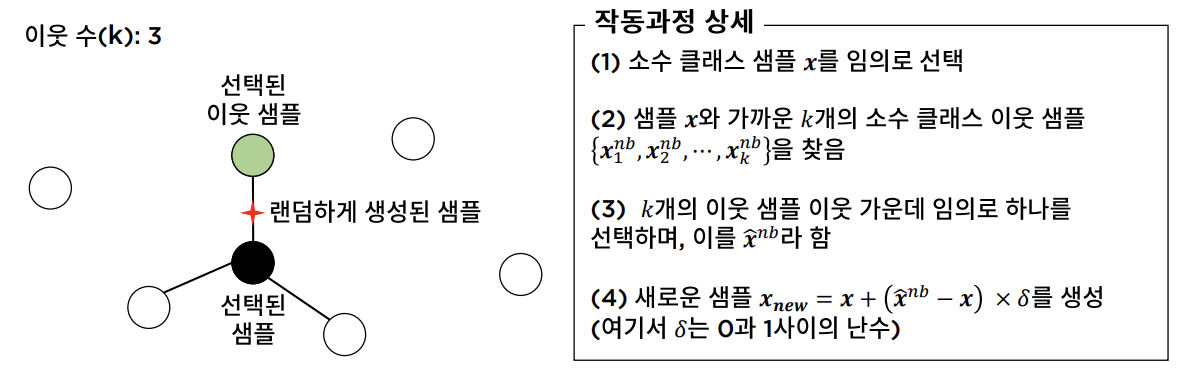

### imblearn.over_sampling.SMOTE
- 주요 입력
  - sampling_strategy: 입력하지 않으면 1:1 비율이 맞을 때까지 샘플을 생성하며, 사전 형태로 입력하여 클래스별로 생성하는 샘플 개수를 조절 가능
  - k_neighbors: SMOTE에서 고려하는 이웃 수(보통 1,3,5 정도로 작게 설정)
- 주요 메서드
  - .fit_sample(X,Y): X와 Y에 대해 SMOTE를 적용한 결과를 ndarray 형태로 반환

### 대표적인 언더샘플링 알고리즘: NearMiss
- 가장 가까운 n개의 소수 클래스 샘플까지 평균 거리가 짧은 다수 클래스 샘플을 순서대로 제거하는 방법
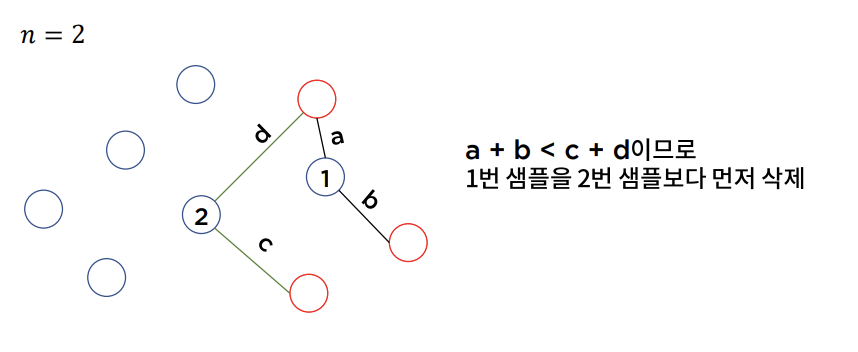

### imblearn.under_sampling.NearMiss
- 주요 입력
  - sampling_strategy: 입력하지 않으면 1:1 비율이 맞을 때까지 샘플을 생성하며, 사전 형태로 입력하여 클래스별로 생성하는 샘플 개수를 조절 가능
  - n_neighbors: 평균 거리를 구하는 소수 클래스 샘플 수
  - version: NearMiss의 version으로, 2를 설정하면 모든 소수 클래스 샘플까지 평균 거리를 사용
- 주요 메서드
  - .fit_sample(X,Y): X와 Y에 대해 NearMiss를 적용한 결과를 ndarray 형태로 반환

In [2]:
import os
import pandas as pd
os.chdir(r'C:\Users\신상훈\Desktop\preprocessing\part-5.-머신러닝-모델의-성능-향상을-위한-전처리\5. 머신러닝 모델의 성능 향상을 위한 전처리\데이터')

In [3]:
df = pd.read_csv('Secom.csv')

In [4]:
# 특징과 라벨 분리
X = df.drop('Y', axis = 1)
Y = df['Y']

In [5]:
# 학습 데이터와 평가 데이터 분할
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)

In [6]:
# 특징이 매우 많음을 확인
Train_X.shape

(1175, 590)

In [7]:
# 클래스 불균형 확인 => 언더샘플링을 적용하기에는 부적절 
Train_Y.value_counts()

-1    1097
 1      78
Name: Y, dtype: int64

In [8]:
# 클래스 불균형 비율 계산
Train_Y.value_counts().iloc[0] / Train_Y.value_counts().iloc[-1]

14.064102564102564

In [9]:
# kNN을 사용한 클래스 불균형 테스트
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import *
kNN_model = KNN(n_neighbors = 11).fit(Train_X, Train_Y)
pred_Y = kNN_model.predict(Test_X)
print(recall_score(Test_Y, pred_Y))
print(accuracy_score(Test_Y, pred_Y))

# 재현율이 0%로 불균형이 심각한 수준이라 보임

0.0
0.9336734693877551


In [10]:
from imblearn.over_sampling import SMOTE
# SMOTE 인스턴스 생성
oversampling_instance = SMOTE(k_neighbors = 3)

# 오버 샘플링 적용
o_Train_X, o_Train_Y = oversampling_instance.fit_sample(Train_X, Train_Y)
# ndarray 형태가 되므로 다시 DataFrame과 Series로 변환 (남은 전처리가 없다면 하지 않아도 무방)
o_Train_X = pd.DataFrame(o_Train_X, columns = X.columns)
o_Train_Y = pd.Series(o_Train_Y)

In [11]:
# 비율이 1:1이 됨을 확인
o_Train_Y.value_counts()

 1    1097
-1    1097
Name: Y, dtype: int64

In [12]:
# 같은 모델로 다시 평가: 정확도는 감소했으나, 재현율이 크게 오름을 확인
kNN_model = KNN(n_neighbors = 11).fit(o_Train_X, o_Train_Y)
pred_Y = kNN_model.predict(Test_X)
print(recall_score(Test_Y, pred_Y))
print(accuracy_score(Test_Y, pred_Y))

0.4230769230769231
0.6096938775510204


In [13]:
from imblearn.over_sampling import SMOTE
# SMOTE 인스턴스 생성
oversampling_instance = SMOTE(k_neighbors = 3, sampling_strategy = {1:int(Train_Y.value_counts().iloc[0] / 2),
                                                                    -1:Train_Y.value_counts().iloc[0]})

# 오버샘플링 적용
o_Train_X, o_Train_Y = oversampling_instance.fit_sample(Train_X, Train_Y)

# ndarray 형태가 되므로 다시 DataFrame과 Series로 변환 (남은 전처리가 없다면 하지 않아도 무방)
o_Train_X = pd.DataFrame(o_Train_X, columns = X.columns)
o_Train_Y = pd.Series(o_Train_Y)

In [15]:
o_Train_Y.value_counts()

-1    1097
 1     548
Name: Y, dtype: int64

In [14]:
kNN_model = KNN(n_neighbors = 11).fit(o_Train_X, o_Train_Y)
pred_Y = kNN_model.predict(Test_X)
print(recall_score(Test_Y, pred_Y))
print(accuracy_score(Test_Y, pred_Y))

0.34615384615384615
0.7397959183673469


## 언더샘플링

In [16]:
df = pd.read_csv("page-blocks0.csv")

In [17]:
# 특징과 라벨 분리
X = df.drop('Class', axis = 1)
Y = df['Class']

In [18]:
# 학습 데이터와 평가 데이터 분할
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)

In [19]:
# 클래스 불균형 확인
Train_Y.value_counts()

negative    3687
positive     417
Name: Class, dtype: int64

In [20]:
Train_Y.replace({"negative":-1, "positive":1}, inplace = True)
Test_Y.replace({"negative":-1, "positive":1}, inplace = True)

In [21]:
# 클래스 불균형 비율 계산
Train_Y.value_counts().iloc[0] / Train_Y.value_counts().iloc[-1]

8.841726618705035

In [22]:
# kNN을 사용한 클래스 불균형 테스트
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import *
kNN_model = KNN(n_neighbors = 11).fit(Train_X, Train_Y)
pred_Y = kNN_model.predict(Test_X)
print(recall_score(Test_Y, pred_Y))
print(accuracy_score(Test_Y, pred_Y))

# 재현율이 60%로 불균형이 심각한 수준은 아니라고 보임

0.6901408450704225
0.9627192982456141


In [23]:
from imblearn.under_sampling import NearMiss
NM_model = NearMiss(version = 2) # version = 2: 모든 소수 클래스 샘플까지의 평균 거리를 활용

# NearMiss 적용
u_Train_X, u_Train_Y = NM_model.fit_sample(Train_X, Train_Y)
u_Train_X = pd.DataFrame(u_Train_X, columns = X.columns)
u_Train_Y = pd.Series(u_Train_Y)

In [24]:
u_Train_Y.value_counts()

 1    417
-1    417
Name: Class, dtype: int64

In [25]:
# kNN 재적용을 통한 성능 변화 확인
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import *
kNN_model = KNN(n_neighbors = 11).fit(u_Train_X, u_Train_Y)
pred_Y = kNN_model.predict(Test_X)
print(recall_score(Test_Y, pred_Y))
print(accuracy_score(Test_Y, pred_Y))

# 재현율은 크게 올랐으나, 정확도가 크게 떨어짐 => 적당한 비율에 맞게 설정해야 함

0.971830985915493
0.21710526315789475


In [26]:
from imblearn.under_sampling import NearMiss
NM_model = NearMiss(version = 2, sampling_strategy = {1:u_Train_Y.value_counts().iloc[-1],
                                                      -1:u_Train_Y.value_counts().iloc[-1] * 5}) # 5:1 정도의 비율로 언더샘플링 재수행

u_Train_X, u_Train_Y = NM_model.fit_sample(Train_X, Train_Y)
u_Train_X = pd.DataFrame(u_Train_X, columns = X.columns)
u_Train_Y = pd.Series(u_Train_Y)

In [27]:
u_Train_Y.value_counts()

-1    2085
 1     417
Name: Class, dtype: int64

In [28]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import *
kNN_model = KNN(n_neighbors = 11).fit(u_Train_X, u_Train_Y)
pred_Y = kNN_model.predict(Test_X)
print(recall_score(Test_Y, pred_Y))
print(accuracy_score(Test_Y, pred_Y))

0.8450704225352113
0.6849415204678363
